In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import NAdam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Model Definitions

In [25]:
import torch
import torch.nn as nn

class AgePredictor(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3, LeakyReLu_slope=0.01):
        super(AgePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1)
        self.leakyrelu = nn.LeakyReLU(negative_slope=LeakyReLu_slope)
        self.dropout = nn.Dropout(p=dropout_rate)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.leakyrelu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leakyrelu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if m is self.fc3:
                    nn.init.xavier_uniform_(m.weight, gain=1.0)
                    nn.init.zeros_(m.bias)
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu', a=0.02)
                    nn.init.normal_(m.bias, mean=0.0, std=0.01)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [30]:
import torch
import torch.nn as nn

class AgePredictor2(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3, LeakyReLu_slope=0.02):
        super(AgePredictor2, self).__init__()
        
        # First Layer
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.act1 = nn.LeakyReLU(LeakyReLu_slope)
        self.drop1 = nn.Dropout(dropout_rate)
        
        # Second Layer
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act2 = nn.LeakyReLU(LeakyReLu_slope)
        self.drop2 = nn.Dropout(dropout_rate)
        
        # Output Layer
        self.fc3 = nn.Linear(256, 1)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if m is self.fc3:
                    nn.init.xavier_uniform_(m.weight, gain=1.0)
                    nn.init.zeros_(m.bias)
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu', a=0.02)
                    nn.init.normal_(m.bias, mean=0.0, std=0.01)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.drop1(self.act1(self.bn1(self.fc1(x))))
        x = self.drop2(self.act2(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

Preprocessing

In [14]:
# Custom Dataset for PyTorch
class AgePredictionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [15]:
def preprocess_data(train_df, test_df, val_size=0.1):
    # Separate features and labels for training data
    X_train_full = train_df.drop(columns=['age'])  # Assuming 'age' is the target column
    y_train_full = train_df['age']

    # Separate features and labels for testing data
    X_test = test_df.drop(columns=['age'])
    y_test = test_df['age']

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, random_state=42,)

    # Normalize the features (scaling them to have 0 mean and 1 standard deviation)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor

Training

Single run test

In [16]:
def train_model(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs=500, learning_rate=0.00005, device=None, weights_path='best_model_weights.pth'):
    model = model.to(device)
    
    train_dataset = AgePredictionDataset(X_train, y_train)
    val_dataset = AgePredictionDataset(X_val, y_val)
    test_dataset = AgePredictionDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

    train_losses, val_losses, test_losses = [], [], []
    patience_model_reload = 25
    best_val_loss = float('inf')
    epochs_without_improvement_model_reload = 0 
    best_model_weights = None
    gradients_per_epoch = {}

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        batch_gradients = {}

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in batch_gradients:
                        batch_gradients[name] = []
                    batch_gradients[name].append(param.grad.clone().detach())

            optimizer.step()
        
        gradients_per_epoch[epoch] = {   
            name: torch.mean(torch.stack(batch_grads), dim=0)
            for name, batch_grads in batch_gradients.items()
        } 

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        total_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train MAE Loss: {avg_train_loss:.4f}, Val MAE Loss: {avg_val_loss:.4f}, Test MAE Loss: {avg_test_loss:.4f}")

        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, weights_path)
            epochs_without_improvement_model_reload = 0 
        else:
            epochs_without_improvement_model_reload += 1
        
        if epochs_without_improvement_model_reload >= patience_model_reload and best_model_weights is not None: 
            print("Restoring the best model weights due to early stopping.")
            model.load_state_dict(torch.load(weights_path)) 
            epochs_without_improvement_model_reload = 0 

    return train_losses, val_losses, test_losses, gradients_per_epoch

Regular

In [36]:
# Read data from CSV
df_train = pd.read_csv("/home/kunaldeo/Julich_IIT_Collab/data/brain_age_parcels/CamCAN/Train_CamCAN_Stratified.csv")
df_test = pd.read_csv("/home/kunaldeo/Julich_IIT_Collab/data/brain_age_parcels/CamCAN/Test_CamCAN_Stratified.csv")
# Preprocess data (including train, validation, and test sets)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df_train,df_test)

device=torch.device('cuda' if torch.cuda.is_available() is True else 'cpu')
model=AgePredictor(input_size=X_train.shape[1], dropout_rate=0.3,LeakyReLu_slope=0.05)
epochs=150
weights_path='/home/kunaldeo/Julich_IIT_Collab/best_weights_test.pth'
train_losses, val_losses, test_losses, gradients_per_epoch=train_model(model,X_train, X_val, X_test, y_train, y_val, y_test,epochs=epochs,weights_path=weights_path)

# Define the filename to save the data
filename = '/home/kunaldeo/Julich_IIT_Collab/Test.pkl'

# Create a dictionary to store the results
training_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'avg_test_loss': test_losses,
    'gradients_per_epoch': gradients_per_epoch
}

# Save the dictionary to a pickle file
with open(filename, 'wb') as f:
    pickle.dump(training_results, f)

print(f"Training results saved to {filename}")

/home/kunaldeo/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/150, Train MAE Loss: 54.7580, Val MAE Loss: 50.8953, Test MAE Loss: 51.5981
Epoch 2/150, Train MAE Loss: 54.4911, Val MAE Loss: 50.9267, Test MAE Loss: 51.6485
Epoch 3/150, Train MAE Loss: 54.4237, Val MAE Loss: 50.7908, Test MAE Loss: 51.4877
Epoch 4/150, Train MAE Loss: 54.3433, Val MAE Loss: 50.7227, Test MAE Loss: 51.4279
Epoch 5/150, Train MAE Loss: 54.1906, Val MAE Loss: 50.5714, Test MAE Loss: 51.2792
Epoch 6/150, Train MAE Loss: 53.8690, Val MAE Loss: 50.4193, Test MAE Loss: 51.1442
Epoch 7/150, Train MAE Loss: 53.6080, Val MAE Loss: 50.2785, Test MAE Loss: 51.0152
Epoch 8/150, Train MAE Loss: 53.4962, Val MAE Loss: 50.1856, Test MAE Loss: 50.9302
Epoch 9/150, Train MAE Loss: 53.5101, Val MAE Loss: 50.0780, Test MAE Loss: 50.8091
Epoch 10/150, Train MAE Loss: 53.2684, Val MAE Loss: 49.9786, Test MAE Loss: 50.7055
Epoch 11/150, Train MAE Loss: 52.9165, Val MAE Loss: 49.8619, Test MAE Loss: 50.5959
Epoch 12/150, Train MAE Loss: 52.8710, Val MAE Loss: 49.7182, Test MAE Los

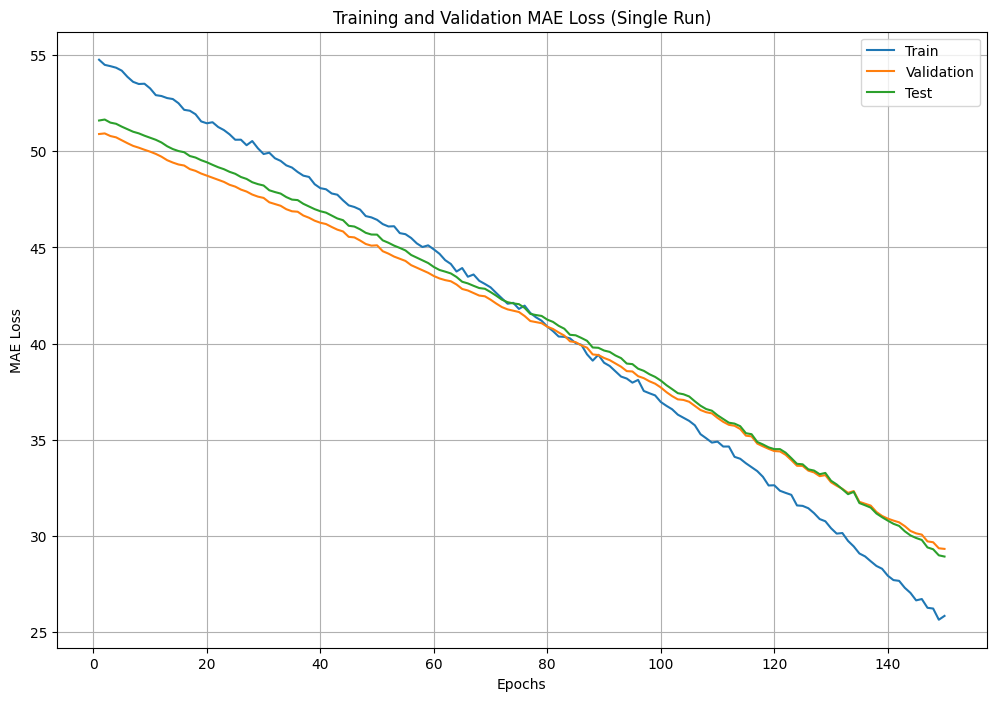

In [37]:
# Assuming final losses are stored in `train_losses` and `val_losses`
epochs_run = epochs  # Fixed number of epochs

# Plotting the training and validation losses
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs_run + 1), train_losses, label='Train')
plt.plot(range(1, epochs_run + 1), val_losses, label='Validation')
plt.plot(range(1, epochs_run + 1), test_losses, label='Test')

plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.title('Training and Validation MAE Loss (Single Run)')
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
#plt.savefig('loss_plot_SALD.png')

# Optionally, you can still show the plot
plt.show()

With Global Set as Test Set

In [ ]:
# Read data from CSV
df_train = pd.read_csv("/home/kunaldeo/Julich_IIT_Collab/data/brain_age_parcels/CamCAN/Train_CamCAN_Stratified.csv")
df_test = pd.read_csv("/home/kunaldeo/Julich_IIT_Collab/data/brain_age_parcels/CamCAN/Test_CamCAN_Stratified.csv")
# Preprocess data (including train, validation, and test sets)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df_train,df_test)

# Separate features and target
# Load the data
global_test_path="/home/kunaldeo/Julich_IIT_Collab/data/brain_age_parcels/eNKI/Test_eNki_Stratified.csv"
global_test_df = pd.read_csv(global_test_path)

# Separate features (X) and target variable (y)
X_test = global_test_df.drop(columns=['age']).to_numpy()
y_test = global_test_df['age']

# Scale the features using StandardScaler
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)  # Scaled features as NumPy array

# Convert to PyTorch tensors and move them to the device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)#.to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)#.to(device)  # Reshape y_test for consistency

device=torch.device('cuda' if torch.cuda.is_available() is True else 'cpu')
model=AgePredictor(input_size=X_train.shape[1], dropout_rate=0.3)
epochs=250
weights_path='/home/kunaldeo/Julich_IIT_Collab/best_weights_test.pth'
train_losses, val_losses, test_losses, gradients_per_epoch=train_model(model,X_train, X_val, X_test_tensor, y_train, y_val, y_test_tensor,epochs=epochs,weights_path=weights_path)

# Define the filename to save the data
filename = '/home/kunaldeo/Julich_IIT_Collab/Experiment0A_Global_Test_SALD_epoch_350.pkl'

# Create a dictionary to store the results
training_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': test_losses,
    'gradients_per_epoch': gradients_per_epoch
}

# Save the dictionary to a pickle file
with open(filename, 'wb') as f:
    pickle.dump(training_results, f)

print(f"Training results saved to {filename}")

/home/kunaldeo/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/350, Train MAE Loss: 46.4733, Val MAE Loss: 46.2325, Test MAE Loss: 35.3382
Epoch 2/350, Train MAE Loss: 46.0527, Val MAE Loss: 46.1827, Test MAE Loss: 35.3097
Epoch 3/350, Train MAE Loss: 44.5344, Val MAE Loss: 46.1029, Test MAE Loss: 35.2338
Epoch 4/350, Train MAE Loss: 44.6118, Val MAE Loss: 45.9442, Test MAE Loss: 35.0958
Epoch 5/350, Train MAE Loss: 44.4409, Val MAE Loss: 45.8430, Test MAE Loss: 35.0139
Epoch 6/350, Train MAE Loss: 43.4514, Val MAE Loss: 45.7214, Test MAE Loss: 34.9042
Epoch 7/350, Train MAE Loss: 45.2366, Val MAE Loss: 45.6426, Test MAE Loss: 34.8493
Epoch 8/350, Train MAE Loss: 45.2504, Val MAE Loss: 45.5784, Test MAE Loss: 34.7886
Epoch 9/350, Train MAE Loss: 42.4584, Val MAE Loss: 45.4712, Test MAE Loss: 34.7097
Epoch 10/350, Train MAE Loss: 43.2248, Val MAE Loss: 45.3679, Test MAE Loss: 34.6107
Epoch 11/350, Train MAE Loss: 44.3105, Val MAE Loss: 45.3102, Test MAE Loss: 34.5562
Epoch 12/350, Train MAE Loss: 44.3837, Val MAE Loss: 45.2031, Test MAE Los

/tmp/ipykernel_1543499/287977964.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


Epoch 293/350, Train MAE Loss: 4.0311, Val MAE Loss: 7.1841, Test MAE Loss: 12.2584
Epoch 294/350, Train MAE Loss: 4.5586, Val MAE Loss: 6.1083, Test MAE Loss: 12.5401
Epoch 295/350, Train MAE Loss: 4.2482, Val MAE Loss: 7.8320, Test MAE Loss: 11.9098
Epoch 296/350, Train MAE Loss: 5.2992, Val MAE Loss: 6.8132, Test MAE Loss: 12.1115
Epoch 297/350, Train MAE Loss: 3.6313, Val MAE Loss: 7.4124, Test MAE Loss: 11.6627
Epoch 298/350, Train MAE Loss: 4.1564, Val MAE Loss: 7.2257, Test MAE Loss: 11.7233
Epoch 299/350, Train MAE Loss: 4.3137, Val MAE Loss: 8.6310, Test MAE Loss: 12.0029
Epoch 300/350, Train MAE Loss: 4.6456, Val MAE Loss: 6.8010, Test MAE Loss: 12.0901
Epoch 301/350, Train MAE Loss: 4.3885, Val MAE Loss: 7.0006, Test MAE Loss: 11.9293
Epoch 302/350, Train MAE Loss: 4.4010, Val MAE Loss: 7.6334, Test MAE Loss: 12.1390
Epoch 303/350, Train MAE Loss: 4.3704, Val MAE Loss: 8.5125, Test MAE Loss: 11.7941
Epoch 304/350, Train MAE Loss: 4.2728, Val MAE Loss: 7.5846, Test MAE Loss: 

ValueError: x and y must have same first dimension, but have shapes (150,) and (350,)

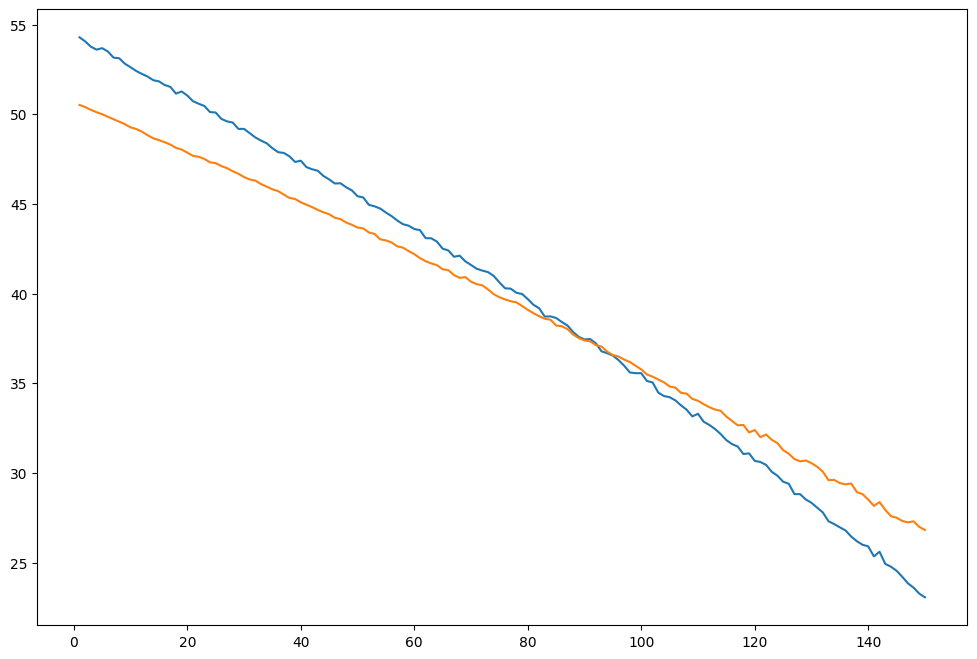

In [18]:
# Assuming final losses are stored in `train_losses` and `val_losses`
epochs_run = epochs  # Fixed number of epochs

# Plotting the training and validation losses
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs_run + 1), train_losses, label='Train')
plt.plot(range(1, epochs_run + 1), val_losses, label='Validation')
plt.plot(range(1, epochs_run + 1), test_losses, label='Test')

plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.title('Training and Validation MAE Loss (Single Run)')
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
#plt.savefig('loss_plot_SALD.png')

# Optionally, you can still show the plot
plt.show()

Multiple runs test

In [102]:

# Number of runs
num_runs = 10

# Store results for all runs
results = []
test_losses_per_run = []  # To store test losses for each run
gradients_per_run = []  # To store gradients for the run with the lowest loss

for run in range(1, num_runs + 1):
    print(f"\nRun {run}/{num_runs}")

    # Instantiate the model
    model = AgePredictor(input_size=X_train.shape[1], dropout_rate=0.3)

    # Loss and optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error for regression task
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

    # Reset variables for this run
    num_epochs = 1000
    train_losses = []
    val_losses = []
    patience_earlystop = 50  # Early Stopping Patience
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_gradients = None

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            # Forward pass
            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, targets)
            total_train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                # Forward pass
                predictions = model(inputs)

                # Compute loss
                loss = criterion(predictions, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Run {run}, Epoch {epoch+1}, Train MAE Loss: {avg_train_loss:.4f}, Val MAE Loss: {avg_val_loss:.4f}")

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0

            # Save the gradients from the model with the best validation loss
            best_gradients = [p.grad.cpu().numpy() for p in model.parameters() if p.grad is not None]
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience_earlystop:
            print("Early stopping")
            break

    # Evaluate on the test set
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses_per_run.append(avg_test_loss)
    print(f"Run {run}, Test MAE Loss: {avg_test_loss:.4f}")

    # Store results for this run
    results.append({
        'run': run,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': avg_test_loss
    })

    # If we have the best gradients, save them to a pickle file
    if best_gradients is not None:
        with open(f'gradients_run_{run}.pkl', 'wb') as f:
            pickle.dump(best_gradients, f)

# Calculate the average test loss across all runs
average_test_loss = sum(test_losses_per_run) / num_runs
print(f"\nAverage Test MAE Loss across {num_runs} runs: {average_test_loss:.4f}")



Run 1/10


/home/kunaldeo/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Run 1, Epoch 1, Train MAE Loss: 35.8597, Val MAE Loss: 34.1647
Run 1, Epoch 2, Train MAE Loss: 35.4447, Val MAE Loss: 33.8635
Run 1, Epoch 3, Train MAE Loss: 35.1626, Val MAE Loss: 33.6287
Run 1, Epoch 4, Train MAE Loss: 34.7235, Val MAE Loss: 33.3514
Run 1, Epoch 5, Train MAE Loss: 34.3978, Val MAE Loss: 33.0611
Run 1, Epoch 6, Train MAE Loss: 33.9320, Val MAE Loss: 32.8412
Run 1, Epoch 7, Train MAE Loss: 33.5988, Val MAE Loss: 32.6005
Run 1, Epoch 8, Train MAE Loss: 33.1885, Val MAE Loss: 32.2278
Run 1, Epoch 9, Train MAE Loss: 32.8967, Val MAE Loss: 31.8336
Run 1, Epoch 10, Train MAE Loss: 32.3930, Val MAE Loss: 31.6140
Run 1, Epoch 11, Train MAE Loss: 32.0041, Val MAE Loss: 31.2868
Run 1, Epoch 12, Train MAE Loss: 31.7065, Val MAE Loss: 30.8546
Run 1, Epoch 13, Train MAE Loss: 31.2720, Val MAE Loss: 30.5703
Run 1, Epoch 14, Train MAE Loss: 30.7988, Val MAE Loss: 30.2534
Run 1, Epoch 15, Train MAE Loss: 30.3116, Val MAE Loss: 29.7443
Run 1, Epoch 16, Train MAE Loss: 30.0194, Val MAE

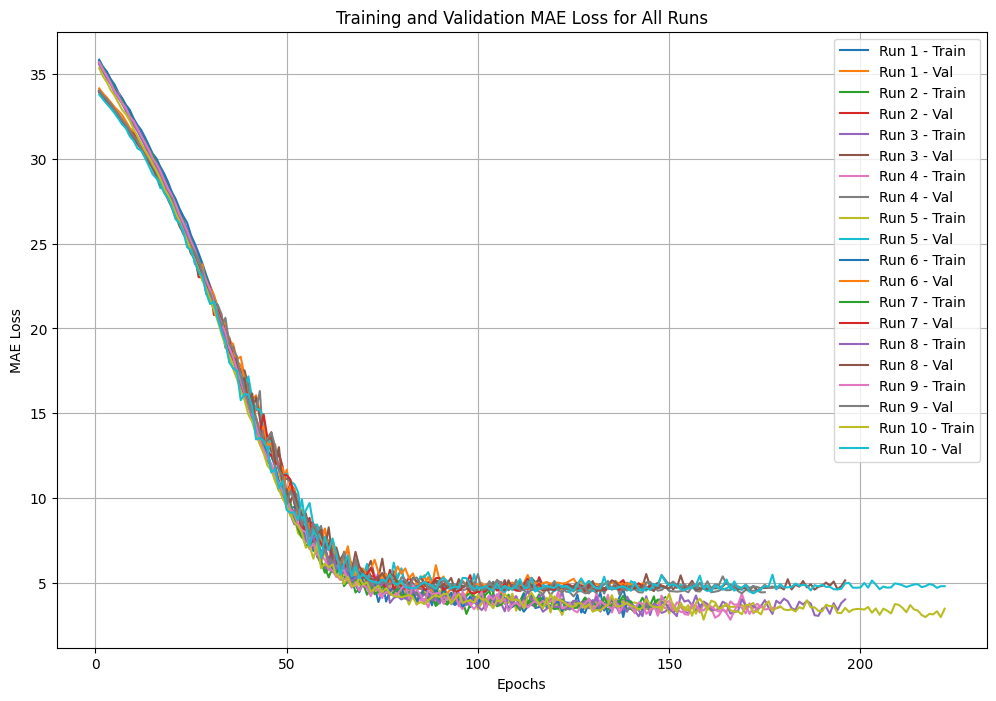

In [103]:
# Plotting the Losses
# Ensure the plot matches the actual number of epochs run
# Plotting the Losses for all runs
plt.figure(figsize=(12, 8))
for result in results:
    run = result['run']
    train_losses = result['train_losses']
    val_losses = result['val_losses']
    epochs_run = len(train_losses)  # Total epochs that actually ran
    plt.plot(range(1, epochs_run + 1), train_losses, label=f'Run {run} - Train')
    plt.plot(range(1, epochs_run + 1), val_losses, label=f'Run {run} - Val')

plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.title('Training and Validation MAE Loss for All Runs')
plt.legend()
plt.grid(True)
plt.show()


Unseen data test

In [97]:
df_unseen = pd.read_csv("Silo1_harmonized.csv")
y = np.asarray(df_unseen["age"])
x = np.asarray(df_unseen.drop(columns=['age']))  # Use df_unseen for feature extraction

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Ensure y_tensor has the correct shape (n_samples, 1)

# Make sure the model is in evaluation mode
model.eval()

# Initialize total test loss
total_test_loss = 0

# No gradients needed for evaluation
with torch.no_grad():
    # Forward pass
    predictions = model(X_tensor)
    
    # Compute loss (Mean Absolute Error)
    loss = criterion(predictions, y_tensor)
    total_test_loss = loss.item()

print(f"The loss on unseen data is: {total_test_loss:.4f}")


The loss on unseen data is: 24.9479
